# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

**Before you turn this problem in, please put your full names and DNIs (or NIEs) below, and execute the cell:**

In [1]:
NAME  = "Pedro Marti Pico"
DNI   = "41574536N"

NAME2 = 'Raixa A. Madueño Mallofré'
DNI2  = '49867599B'

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. **Justify** all of your answers, **graphically** wherever possible. Remember that this notebook will be considered as a report to the work done during the assignment.

---

In [2]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import skimage.feature as skfeat
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
import iric_dev_kit.iric_utils.eval_holidays as ev

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
In this assignment, you will first learn the tools that we will used during the labs. Then, you will implement and evaluate some image description methods to develop a simple CBIR system.

### Tools
Several tools and libraries will be used throughout the semester, like:

*   [Python 3](https://docs.python.org/3/tutorial/)
*   [Numpy](https://docs.scipy.org/doc/numpy/user/quickstart.html)
*   [OpenCV](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)

It is important to be familiar with them. If that is not the case, please, follow the links above and have a look at the tutorials. There are some quickstart guides available on the course website on [Aula Digital](https://ad.uib.es/).

### The INRIA Holidays dataset
During this course, we will mainly use the INRIA Holidays dataset. This dataset is a set of images which contains some personal holidays photos of the authors. The remaining ones were taken on purpose to test the robustness to various image transformations: rotations, viewpoint and illumination changes, blurring, etc. The dataset includes a very large variety of scene types (natural, man-made, water, fire effects, etc) and images are in high resolution. The dataset contains 500 image groups, each of which represents a distinct scene or object. 

For evaluation purposes, the first image of each group is used as the query image and the correct retrieval results are the other images of the group. For instance, the image named *100900.jpg* will be used as query while the corresponding relevant images for this query are images *100901.jpg* and *100902.jpg*, which belongs to the same group.

There are **1491 images in total**, from which **500** are **queries** (one for each group) and the remaining **991** are their corresponding **relevant images**.

### The INRIA Holidays Mini dataset
For development purposes, a small version of the INRIA Holidays dataset is provided for this course. In this reduced version of the dataset, there are **50 images in total**, from which **19** are **queries** and the remaining **31** are their corresponding **relevant images**.

> **Both datasets must be downloaded from [Aula Digital](https://ad.uib.es/) and unzipped into the root directory of the development kit**.

### Performance evaluation
You are provided with a script to evaluate a CBIR system on these datasets. The performance is measured in terms of **Mean Average Precision** (mAP), averaged over all queries (500 or 19, depending on the version of the dataset used). **This script is included in the development kit**.

This library provides two ways of calculating the mAP for a given set of results:
* Using the function `compute_mAP_from_file()`, which receives as parameters:
    * A resulting file following the original format provided by the authors (see any of the `perfect_result_*.dat` files provided as an example)
    * The ground truth file
  
We provide a perfect results file for each version of the dataset computed from the ground truth as an example:

In [3]:
# Computing mAPs using ground truths
#m_ap = ev.compute_mAP_from_file('holidays/perfect_result.dat', 'holidays/holidays_images.dat')
#print('mAP: %.5f' % m_ap)

m_ap = ev.compute_mAP_from_file('holidays_mini/perfect_result_mini.dat', 'holidays_mini/holidays_images.dat')
print('mAP: %.5f' % m_ap)

mAP: 1.00000


* Using the function `compute_mAP()`, which receives:
    * The query results as a dictionary (Execute the next cell to see an example of the format of this dictionary)
    * The ground truth file
  
You should use this version if you don't want to save your results into a temporary file. This dictionary should contain, for each query image, an ordered list of the retrieved images. For example:

In [4]:
# Reading the ground truth file to create a perfect results dictionary
res = {}
with open('holidays_mini/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
    
        # Checking if this is a query image
        if imno % 100 == 0:
            results = []
            res[imname] = results
        else:
            results.append(imname)
print(res)

{'100000.jpg': ['100001.jpg', '100002.jpg'], '100100.jpg': ['100101.jpg'], '100200.jpg': ['100201.jpg'], '100300.jpg': ['100301.jpg', '100302.jpg'], '100400.jpg': ['100401.jpg'], '100500.jpg': ['100501.jpg', '100502.jpg', '100503.jpg'], '100600.jpg': ['100601.jpg'], '100700.jpg': ['100701.jpg'], '100800.jpg': ['100801.jpg'], '100900.jpg': ['100901.jpg', '100902.jpg'], '101000.jpg': ['101001.jpg'], '101100.jpg': ['101101.jpg'], '101200.jpg': ['101201.jpg'], '101300.jpg': ['101301.jpg'], '101400.jpg': ['101401.jpg', '101402.jpg', '101403.jpg', '101404.jpg'], '101500.jpg': ['101501.jpg', '101502.jpg', '101503.jpg', '101504.jpg'], '101600.jpg': ['101601.jpg'], '101700.jpg': ['101701.jpg', '101702.jpg'], '101800.jpg': ['101801.jpg']}


Then you can use this dictionary as the input parameters to the corresponding function to validate a CBIR system:

In [5]:
m_ap = ev.compute_mAP(res, 'holidays_mini/holidays_images.dat')
print('mAP: %.5f' % m_ap)

mAP: 1.00000


### Loading images

For managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In [6]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

with open('holidays_mini/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread('holidays_mini/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_imgs))
print(len(train_imgs))

19
31


### Visualizing results
Additionally, you are also provided with a class called `ResultViz`, which includes two functions (`show_results` and `show_one_result`) to show graphically the retrieved results for a specific query. Here are some examples of how to use this class:

In [7]:
# Create the visualization object
rv = ev.ResultViz(query_names, query_imgs, train_names, train_imgs)

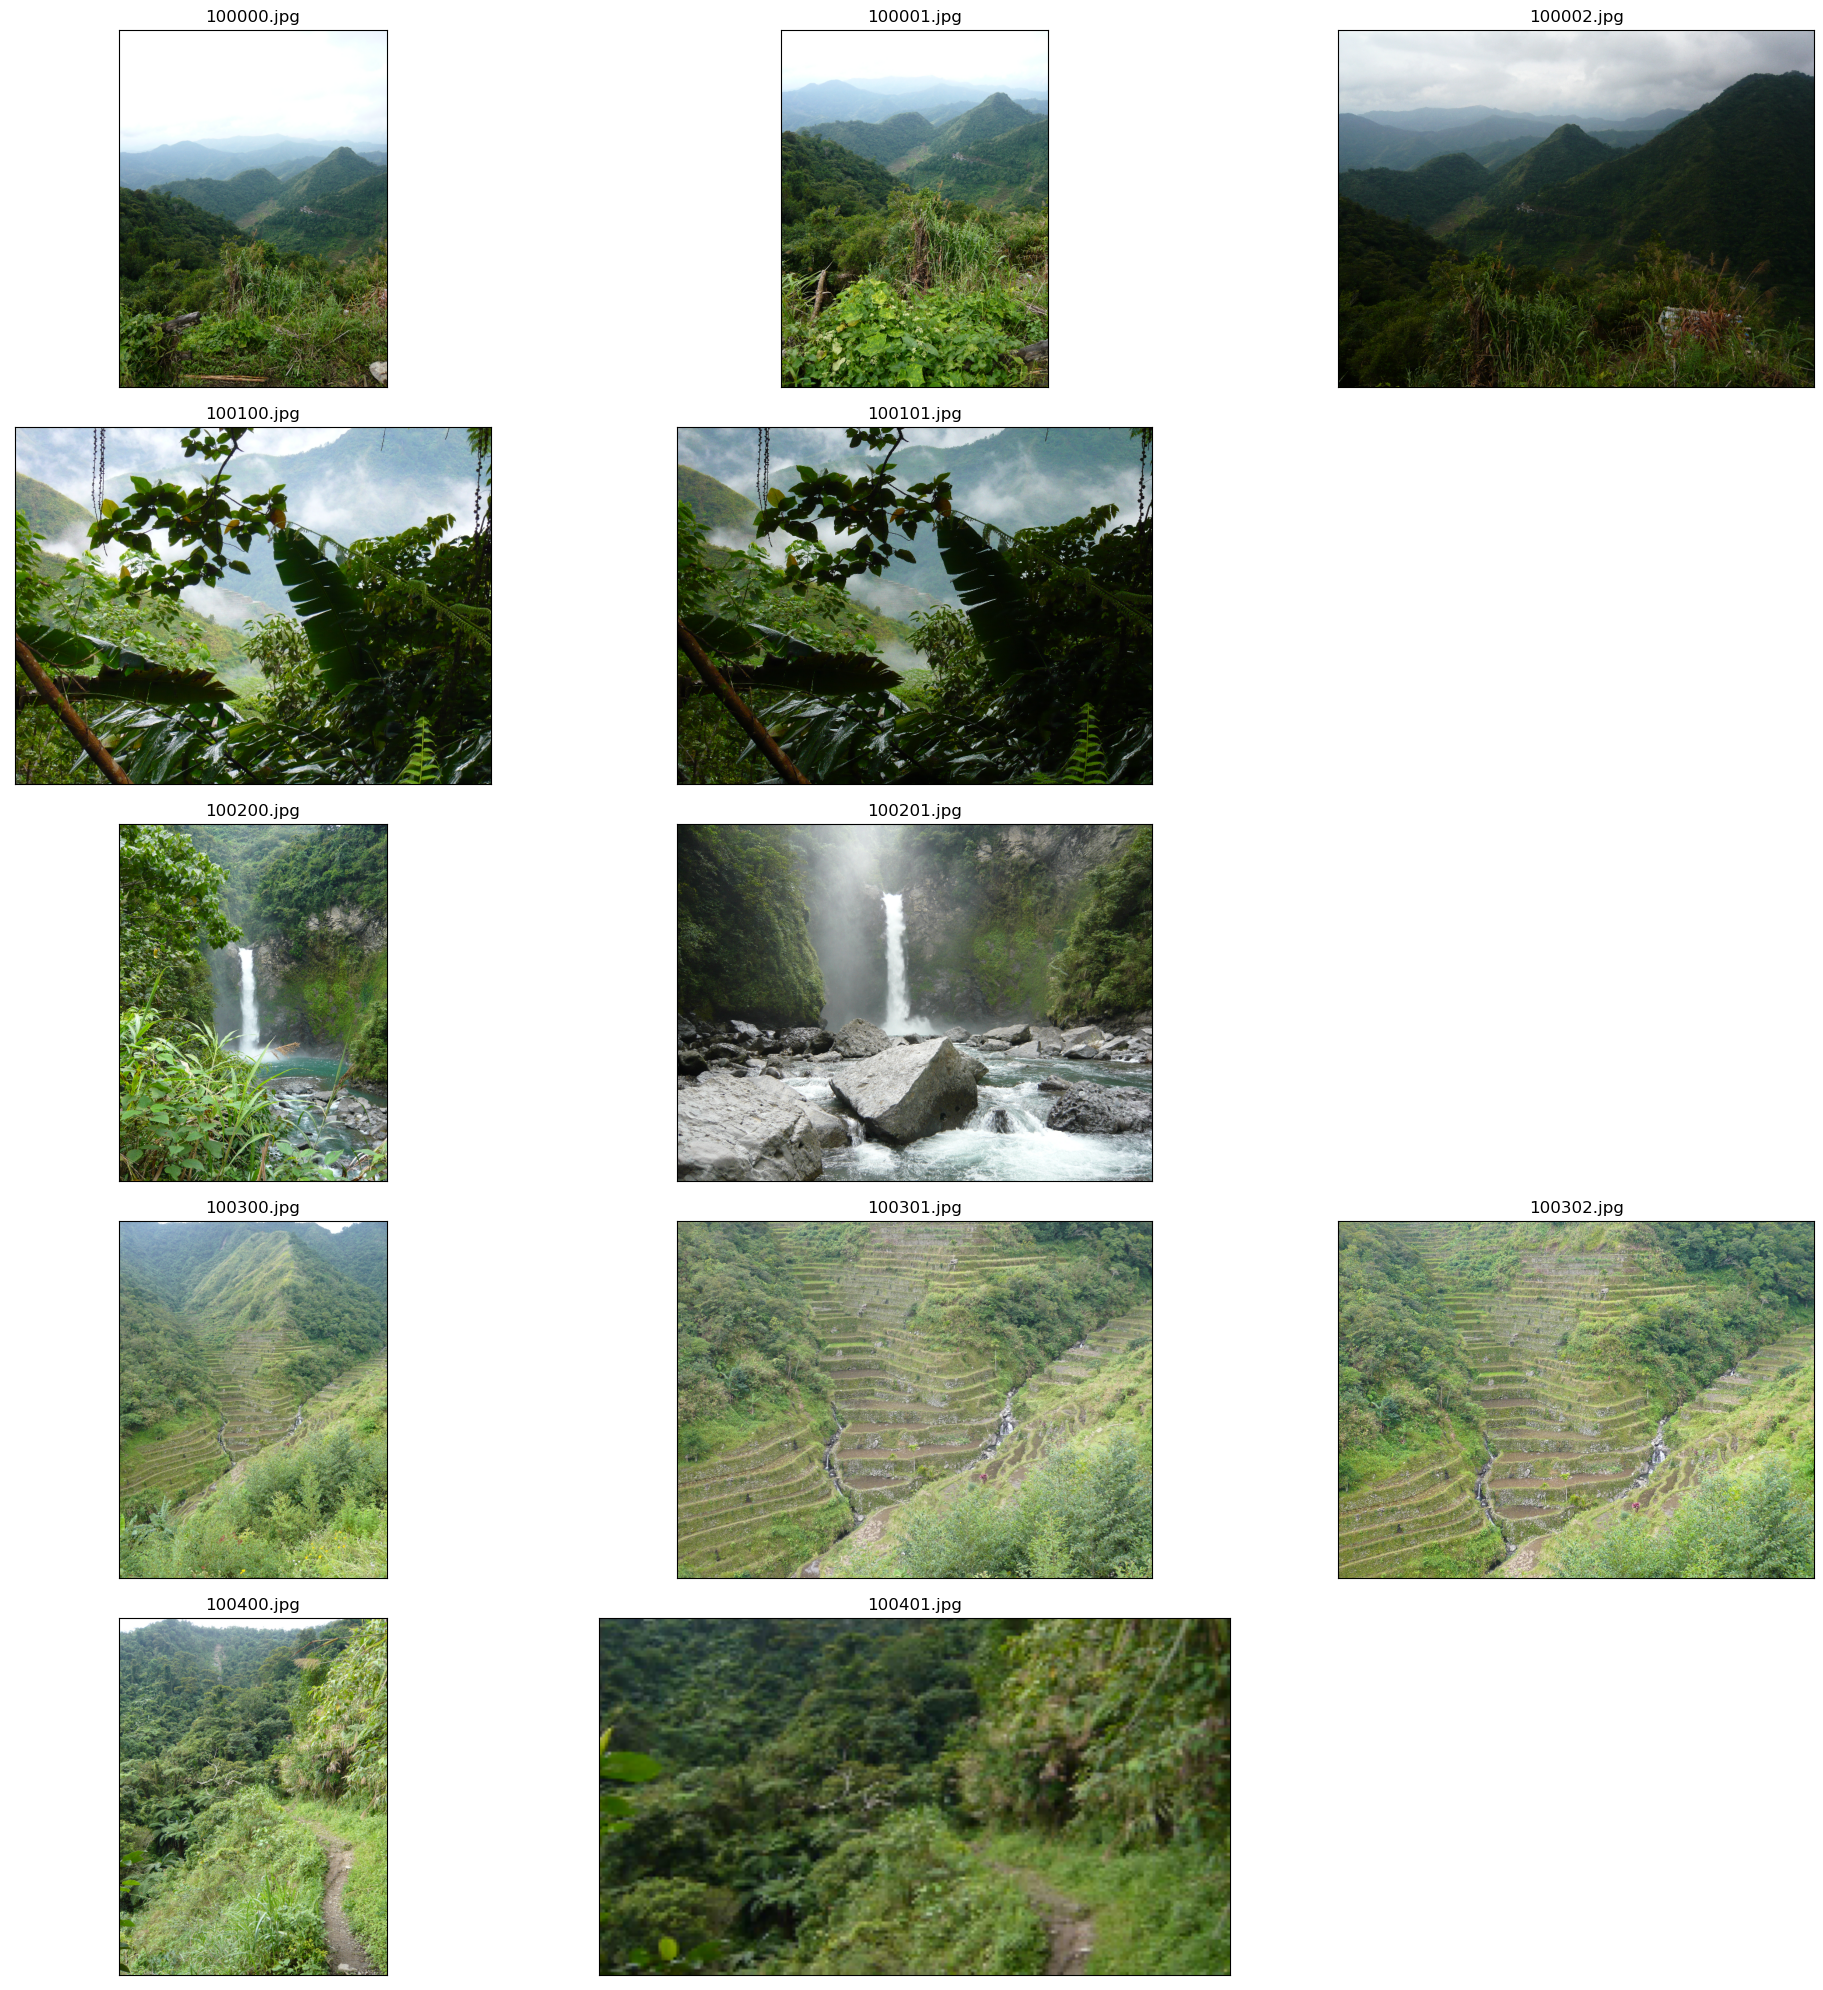

In [8]:
# Show the best 2 retrieved images for the first 5 queries
rv.show_results(res, nqueries = 5, ntrains = 2)

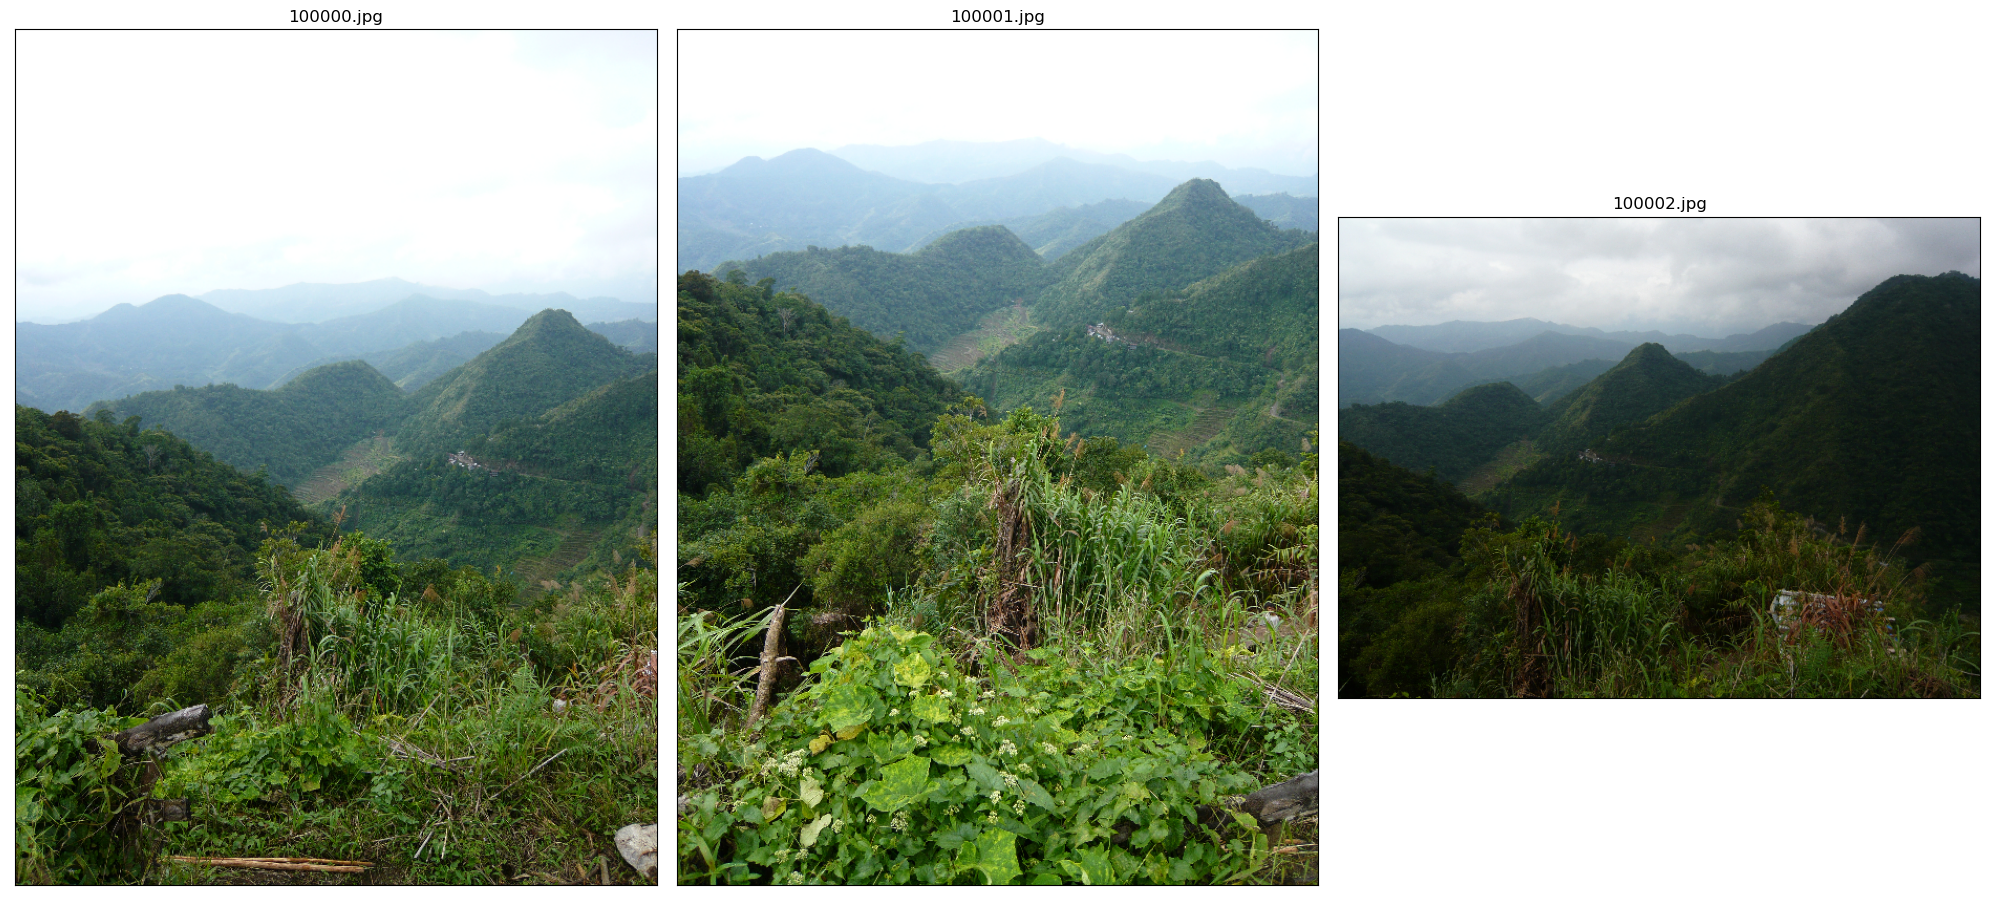

In [9]:
# Show the best 2 retrieved images for the query image '100000.jpg'
rv.show_one_result(res, '100000.jpg', ntrains = 2)

## Global descriptors
Once we have our development environment ready, it is time to start coding the assignment. At this section, we will use and evaluate some global descriptors to develop a simple image retrieval system.

### General framework
First, we will develop some utilities to simplify our work. Write a [Python class](https://docs.python.org/3/tutorial/classes.html) called `CBIR` that will encapsulate the main functionalities of a CBIR system, using the provided descriptions for each method. Assume that there exists a function that can compute a global descriptor of a given image called `desc_func`, which will be implemented later in the assignment:

In [10]:
class CBIR:
    """
    Class to encapsulate the basic functionalities of a CBIR system.
    """
    
    def __init__(self, desc_func, **kwargs):
        """
        Class constructor.
        
        - desc_func: The function to be used for describing the images
        - kwargs: A variable number of parameters required to call desc_func.
            This is a dictionary that can be unpacked within the function.
            See more info here: https://realpython.com/python-kwargs-and-args/
        """
        self.desc_func = desc_func
        self.kwargs = kwargs
        
    def build_db(self, train_names, train_imgs):
        """
        Create the CBIR system database.
        
        - train_names: An ordered list of the names of the train images
        - train_imgs:  An ordered list of train images (Numpy arrays)
        
        This function should describe each image using desc_func and save the 
        resulting descriptors in a list of numpy arrays called train_descs.
        You should also save the names of each image in an attribute called
        train_names to associate each train image to its corresponding name.
        """
      
        self.train_names = train_names
        self.train_descs = {name: self.desc_func(img, **self.kwargs) for name, img in zip(train_names, train_imgs)}
        
    def search_image(self, query_img):
        """
        Search an image in the system.
        
        - query_img: Query image (Numpy array)
        
        RETURNS:
        - An ordered list of tuples, each one with the format (L2 distance, train image name)
        
        This function should describe the query image using desc_func. Next, the resulting
        descriptor should be used to generate a list where each element is a tuple 
        (L2 distance, train image name), ordered according to the L2 distance between 
        the query descriptor and each corresponding train descriptor.
        """  
        query_descriptor = self.desc_func(query_img, **self.kwargs)
        distances = []
        # print(f"train desc {self.train_descs}")
        
        for name, train_descriptor in self.train_descs.items():
            l2_distance = np.linalg.norm(query_descriptor - train_descriptor)
            distances.append((l2_distance, name))
        distances.sort()
        return distances
    
    def compute_mAP(self, query_names, query_imgs, gt_file):
        """
        Compute the mAP of a list of query images against the database.
        
        - query_names: An ordered list with the names of query images
        - query_imgs: An ordered list of query images (Numpy arrays)
        - gt_file = Ground truth file. Typically, 'holidays_images.dat'.
        
        RETURN: 
        - total_results: A dictionary containing, for each query image, an ordered list 
            of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        
        This function should use search_image and compute_mAP to compute the mAP of a set 
        of queries against the database. You should return the final resulting 
        dictionary, formatted as explained previously, and the computed mAP.
        You can limit the number of results returned for each query image and check 
        how the mAP is affected.
        """

        total_results = {}
        m_ap = 0.0
        
        for name, img in zip(query_names, query_imgs):
            r_image = self.search_image(img) # Esto nos la distancia entre L2
            total_results[name] = [img for _, img in r_image]
        m_ap += ev.compute_mAP(total_results, gt_file)
        
        return total_results, m_ap
    
    def desc_func(img, bins_per_hist = 32):
        """
        Compute a 1d color histogram of the image.

        - img: Color image (Numpy array)
        - bins_per_hist: Number of bins per histogram
        RETURN:
        - A numpy array of shape (bins_per_hist * 3,)
        """
        # Convert the image to the HSV color space
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        # Compute the color histogram
        hist = cv2.calcHist([img_hsv], [0, 1, 2], None, [bins_per_hist]*3, [0, 180, 0, 256, 0, 256])
        # Normalize the histogram
        cv2.normalize(hist, hist)
        # Flatten the histogram into a 1D array
        hist_flattened = hist.flatten()
        return hist_flattened

### Color histograms
Let's start with histograms. Write a function for computing a descriptor based on 1D color histograms called `compute_1d_color_hist`. The final descriptor of the image will be the concatenation of the **normalized** color histograms of the three individual channels (B, G and R):

> **Useful functions**: [cv2.calcHist](https://docs.opencv.org/4.2.0/d6/dc7/group__imgproc__hist.html), [np.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)

In [11]:
def compute_1d_color_hist(img, bins_per_hist = 32):
    """
    Compute a 1d color histogram of the image.
  
    - img: Color image (Numpy array)
    - bins_per_hist: Number of bins per histogram

    RETURN: 
    - A numpy array of shape (bins_per_hist * 3,)
    """
    hist_r = np.histogram(img[:,:,0].flatten(), bins=bins_per_hist)[0]
    hist_g = np.histogram(img[:,:,1].flatten(), bins=bins_per_hist)[0]
    hist_b = np.histogram(img[:,:,2].flatten(), bins=bins_per_hist)[0]
    his = np.concatenate([hist_r, hist_g, hist_b])
    return his

In [12]:
# Bins: 32
h = compute_1d_color_hist(train_imgs[0], 32);
assert h.shape == (96, )

In [13]:
# Bins: 16
h = compute_1d_color_hist(train_imgs[0], 16);
assert h.shape == (48, )

In [14]:
# Bins: 8
h = compute_1d_color_hist(train_imgs[0], 8);
assert h.shape == (24, )

**Q1**: Using this function and the `CBIR` class you wrote before, in the following cell compute the resulting **mAP** of the system **using 32 bins per histogram**:

In [15]:
# Fill this variable with the resulting mAP
mAP_hist_1d = 0.0

# Create an instance of CBIR with compute_1d_color_hist as the descriptor function
cbir = CBIR(compute_1d_color_hist, bins_per_hist=32)

# Build the database with the training images
cbir.build_db(train_names, train_imgs)

# Compute the mAP
total_results, mAP_hist_1d = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')

In [16]:
print('mAP: %.5f' % mAP_hist_1d)

mAP: 0.77666


**Q2**: What is the effect of changing the number of bins per histogram?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [17]:
arr_bins_per_hist = [16, 64]

for bins_per_hist in arr_bins_per_hist:
    print(f"Calculating mAP_hist_1d for {bins_per_hist} bins per histogram ")
    # Create an instance of CBIR with compute_1d_color_hist as the descriptor function
    cbir = CBIR(compute_1d_color_hist, bins_per_hist=bins_per_hist)
    cbir.build_db(train_names, train_imgs)
    total_results, mAP_hist_1d = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')
    print(f"mAP_hist_1d: {mAP_hist_1d:.5f}\n")

Calculating mAP_hist_1d for 16 bins per histogram 
mAP_hist_1d: 0.75305

Calculating mAP_hist_1d for 64 bins per histogram 
mAP_hist_1d: 0.77429



#### Q2 Response  
The number of bins in a histogram affects the granularity of the color representation in an image. Increasing the number of bins captures more detailed color information, while decreasing it captures broader color ranges.
When it comes to holiday images, using fewer bins may result in the model capturing the overall colour themes of the holidays, while using more bins may focus on specific colour details.

However, the relationship between the number of bins and the mean Average Precision (mAP) is not linear. For example, changing the number of bins to 16 or 64 resulted in a lower mAP than when using 32 bins. There appears to be an optimal level of granularity for this task and dataset. Both excessive detail (64 bins) and insufficient detail (16 bins) can negatively impact performance.

---
Now write a function called `compute_2d_color_hist` for computing a global descriptor of the image using 2D color histograms. The descriptor of the image will be the concatenation of the **normalized** histograms emerging from the three possible combinations of color channels (B/G, B/R and G/R):

In [18]:
def compute_2d_color_hist(img, bins_per_hist = 16):
    """
    Compute a 2d color histogram of the image.
    
    The final descriptor will be the concatenation of 3 normalized 2D histograms: B/G, B/R and G/R.
  
    - img: Color image (Numpy array)
    - bins_per_hist: Number of bins per histogram

    RETURN:
    - A numpy array of shape (bins_per_hist * bins_per_hist * 3,)
    """
    # Split the image into its B, G, R components
    (B, G, R) = cv2.split(img.astype("uint8"))  # Change "float" to "uint8"
    
    # Compute the 2D color histograms for the B/G, B/R, and G/R color spaces
    histBG = cv2.calcHist([B, G], [0, 1], None, [bins_per_hist, bins_per_hist], [0, 256, 0, 256])  # Fix bin format
    histBR = cv2.calcHist([B, R], [0, 1], None, [bins_per_hist, bins_per_hist], [0, 256, 0, 256])  # Fix bin format
    histGR = cv2.calcHist([G, R], [0, 1], None, [bins_per_hist, bins_per_hist], [0, 256, 0, 256])  # Fix bin format
    
    # Normalize the histograms
    cv2.normalize(histBG, histBG)
    cv2.normalize(histBR, histBR)
    cv2.normalize(histGR, histGR)
    
    # Concatenate the histograms into a single feature vector
    hist = np.concatenate((histBG.flatten(), histBR.flatten(), histGR.flatten()))
    
    return hist

In [19]:
# Bins: 32
h = compute_2d_color_hist(train_imgs[0], 32)
assert h.shape == (3072, )

In [20]:
# Bins: 16
h = compute_2d_color_hist(train_imgs[0], 16)
assert h.shape == (768, )

**Q3**: Using this function and the `CBIR` class you wrote before, in the following cell compute the resulting **mAP** of the system **using 32 bins per histogram**:

In [21]:
# Fill this variable with the resulting mAP
mAP_hist_2d = 0.0

# Create an instance of CBIR with compute_1d_color_hist as the descriptor function
cbir = CBIR(compute_2d_color_hist, bins_per_hist=32)

# Build the database with the training images
cbir.build_db(train_names, train_imgs)

# Compute the mAP
total_results, mAP_hist_2d = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')

In [22]:
print('mAP: %.5f' % mAP_hist_2d)

mAP: 0.72543


**Q4**: What is the effect of changing the number of bins per histogram?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [23]:
arr_bins_per_hist = [16, 14, 8]

for bins_per_hist in arr_bins_per_hist:
    print(f"Calculating mAP_hist_2d for {bins_per_hist} bins per histogram ")
    # Create an instance of CBIR with compute_1d_color_hist as the descriptor function
    cbir = CBIR(compute_2d_color_hist, bins_per_hist=bins_per_hist)
    cbir.build_db(train_names, train_imgs)
    total_results, mAP_hist_2d = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')
    print(f"mAP_hist_2d: {mAP_hist_2d:.5f}\n")

Calculating mAP_hist_2d for 16 bins per histogram 
mAP_hist_2d: 0.81779

Calculating mAP_hist_2d for 14 bins per histogram 
mAP_hist_2d: 0.82326

Calculating mAP_hist_2d for 8 bins per histogram 
mAP_hist_2d: 0.81791



#### Q4 Response


Changing the number of bins in the compute_2d_color_hist function can affect the mAP. More bins per histogram may capture more noise or overfit to specific color values, which could be detrimental when dealing with diverse holiday images. Fewer bins can capture broader color ranges, which could be more relevant for distinguishing between different types of holiday images.  
Reducing the number of bins from 32 to 16, 8, or 14 improved the mAP. This suggests that a coarser color representation might be more effective for this specific task and dataset. However, the relationship between the number of bins and the mAP is not linear and is influenced by the content of the dataset, as observed in the 1D case.

### Local Binary Patterns (LBP)

Let's try LBP. Implement a function called `compute_lbp_descriptor` to calculate an image descriptor based on LBP's. The descriptor of the image should use the _rotation invariant_ and _uniform_ (_riu_) version of the algorithm. The final image descriptor will be the **normalized** histogram of the resulting LBP image:

> **Useful functions**: [skimage.feature.local_binary_pattern](https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern)

In [24]:
def compute_lbp_descriptor(img, p = 8, r = 1):
    """
    Compute a rotation invariant and uniform LBP histogram as image descriptor.
  
    - img: Input image (Numpy array)
    - p: Neighbors to check in radius r
    - r: Radius in pixels

    RETURN: 
    - A numpy array of shape (p + 2,)
    """    
    if len(img.shape) != 2: # NOS ASEGURAMOS QUE TENGA DOS CANALES DE COLORES
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    LBP = skfeat.local_binary_pattern(img, p, r, method='uniform')
    histogram, _ = np.histogram(LBP, bins=p+2, density=True, range=(0, p+2))
    return histogram


In [25]:
h = compute_lbp_descriptor(train_imgs[0], 8, 1);
assert h.shape == (10, )

**Q5**: Using this function and the `CBIR` class you wrote before, in the following cell compute the resulting **mAP** of the system **checking 8 neighbors for each pixel at a distance of 1**:

In [26]:
# Fill this variable with the resulting mAP
mAP_lbp = 0.0

cbir = CBIR(compute_lbp_descriptor, p = 8, r = 1)

cbir.build_db(train_names, train_imgs)

total_results, mAP_lbp = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')

In [27]:
print('mAP: %.5f' % mAP_lbp)

mAP: 0.59915


**Q6**: What is the effect of modifying the number of neighboring pixels $p$ and the radius $r$?

In [28]:
p_values = [4, 8, 16]
r_values = [1, 2, 3]

for p in p_values:
    for r in r_values:
        print(f"Calculating mAP_lbp for p={p} and r={r}")
        cbir = CBIR(compute_lbp_descriptor, p=p, r=r)
        cbir.build_db(train_names, train_imgs)
        total_results, mAP_lbp = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')
        print(f"mAP_lbp: {mAP_lbp:.4f}\n")

Calculating mAP_lbp for p=4 and r=1
mAP_lbp: 0.5965

Calculating mAP_lbp for p=4 and r=2
mAP_lbp: 0.5008

Calculating mAP_lbp for p=4 and r=3
mAP_lbp: 0.4729

Calculating mAP_lbp for p=8 and r=1
mAP_lbp: 0.5991

Calculating mAP_lbp for p=8 and r=2
mAP_lbp: 0.5146

Calculating mAP_lbp for p=8 and r=3
mAP_lbp: 0.5181

Calculating mAP_lbp for p=16 and r=1
mAP_lbp: 0.6047

Calculating mAP_lbp for p=16 and r=2
mAP_lbp: 0.5357

Calculating mAP_lbp for p=16 and r=3
mAP_lbp: 0.5105



#### Q6 Response

The given results mean that increasing the **p** value from 4 to 8 improves de mAP, that means that a denser sampling of the neighboring pixels around each central pixel can capture more detailed texture information. But, incresing 8 to 16 is not always a better mAP, what means that incresing the **p** value doesn't result in a more improved mAP, because there should be an optimal point that the descriptor works better with.

For the **r** value, increasing it generally results in a lower mAP, because a larger radius captures broader patterns in the image and it can not be as discriminative as a image retrival task needs. Also incorporating more noise and non-important information.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

**Q7**: Study the effect of using a grid to describe the image.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

Divide the image into smaller grids and computing the LBP histogram for each grid. 

In [29]:
def compute_lbp_grid_descriptor(img, p=8, r=1, grid_size=1):
    """
    Compute a rotation invariant and uniform LBP histogram as image descriptor using a grid.

    - img: Input image (Numpy array)
    - p: Neighbors to check in radius r
    - r: Radius in pixels
    - grid_size: Size of the grid to divide the image into

    RETURN:
    - A numpy array of shape (grid_size^2, p + 2)
    """
    # Convert the image to grayscale 
    if len(img.shape) != 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get the height and width of the image
    height, width = img.shape

    # Calculate the height and width of each grid
    grid_height = height // grid_size
    grid_width = width // grid_size

    # Initialize the descriptors array with the appropriate size
    descriptors = np.zeros((grid_size**2, p+2))
    index = 0

    # Loop through each grid in the image
    for i in range(0, height, grid_height):
        for j in range(0, width, grid_width):
            # Extract the cell image from the current grid
            cell_img = img[i:i+grid_height, j:j+grid_width]

            # Compute the LBP histogram for the cell image
            LBP = skfeat.local_binary_pattern(cell_img, p, r, method='uniform')
            histogram, _ = np.histogram(LBP, bins=p+2, density=True, range=(0, p+2))

            # Store the histogram in the descriptors array
            descriptors[index] = histogram
            index += 1

            # Break the loops if the index exceeds the size of descriptors
            if index >= grid_size**2:
                break
        if index >= grid_size**2:
            break

    # Return the descriptors array
    return descriptors

In [30]:
grid_sizes = [1, 2, 4]

for grid_size in grid_sizes:
    print(f"Calculating mAP_lbp for grid size {grid_size}")
    cbir = CBIR(compute_lbp_grid_descriptor, p=8, r=1, grid_size=grid_size)
    cbir.build_db(train_names, train_imgs)
    total_results, mAP_lbp = cbir.compute_mAP(query_names, query_imgs, 'holidays_mini/holidays_images.dat')
    print(f"mAP_lbp: {mAP_lbp:.4f}\n")

Calculating mAP_lbp for grid size 1
mAP_lbp: 0.5991

Calculating mAP_lbp for grid size 2
mAP_lbp: 0.6753

Calculating mAP_lbp for grid size 4
mAP_lbp: 0.6515



#### Q7 Response  

The grid_size choice can impact the model's performance, as measured by mean Average Precision. The grid_size refers to the number of equally sized cells that the image is divided into. The image is divided into a grid of grid_size x grid_size cells, and the LBP descriptor is computed separately for each cell. A smaller grid_size captures less detailed texture information with greater noise and small variation robustness. A larger grid_size captures more detailed texture information but may be more sensitive to noise and small variations.

The results indicate that a grid_size of 2 achieves the highest mAP, suggesting that this level of granularity in texture representation is most effective for the given objective and dataset. It is important to note that the relationship between grid_size and mAP may not be linear and can depend on the specific characteristics of the dataset. For instance, holiday images may vary in texture detail, and the optimal grid size may depend on the trade-off between capturing this detail and avoiding overfitting to noise or small variations. Trying different values can be helpful in determining the most suitable one for the specific use case.

## Local descriptors
In this section we are going to retrieve images using some of the local descriptors we covered in class.

### Keypoint extraction / description

Let's start by writing a function called `extract_interest_points` to extract a set of keypoints from an image and their corresponding descriptors. The function will receive a parameter called `feat_type` to indicate what method should be used to detect and describe keypoints. This parameter can have one of the following string values:
- `SIFT`: SIFT detector / descriptor
- `FAST_BRIEF`: FAST detector / BRIEF descriptor
- `ORB`: ORB detector / ORB descriptor

> **Useful functions**: [cv2.SIFT_create()](https://docs.opencv.org/4.5.4/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131),  [cv2.FastFeatureDetector_create](https://docs.opencv.org/4.5.4/df/d74/classcv_1_1FastFeatureDetector.html#ab986f2ff8f8778aab1707e2642bc7f8e), [cv2.xfeatures2d.BriefDescriptorExtractor_create](https://docs.opencv.org/4.5.4/d1/d93/classcv_1_1xfeatures2d_1_1BriefDescriptorExtractor.html#ae3bc52666010fb137ab6f0d32de51f60), [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [31]:
def extract_interest_points(img, feat_type = 'SIFT', nfeats = 500, thresh = 50):
    """
    Compute keypoints and their corresponding descriptors from an image.
  
    - img: Input image (Numpy array)
    - feat_type: Detection / description method. See cell above
    - nfeats: Maximum number of features. It can be directly used to configure SIFT and ORB.
    - thresh: Detection threshold. Useful for FAST and ORB.
  
    RETURN:
    - kp: A tuple with the detected keypoints (cv2.KeyPoint)
    - des: A numpy array of shape (number_of_kps, descriptor_size) of type:
        - 'np.float32' for SIFT
        - 'np.uint8' for BRIEF and ORB
    """
    kp = []
    des = []

    if feat_type == 'SIFT':
        sift = cv2.SIFT_create(nfeatures=nfeats)
        '''
        SIFT detector is used, the des variable is a 
        Numpy array of shape (number_of_kps, descriptor_size) of type np.float64.
        '''
        kp, des = sift.detectAndCompute(img, None)
        des = des.astype(np.float32)  # Convert descriptor array to np.float32
    elif feat_type == 'FAST_BRIEF':
        fast = cv2.FastFeatureDetector_create(threshold=thresh)
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        kp = fast.detect(img, None)
        kp, des = brief.compute(img, kp)
        des = des.astype(np.uint8)  # Convert descriptor array to np.uint8
    elif feat_type == 'ORB':
        orb = cv2.ORB_create(nfeatures=nfeats, fastThreshold=thresh)
        '''
        In the OpenCV library, the ORB feature detector computes descriptors of type CV_8U, 
        which is equivalent to np.uint8 in Numpy. 
        Therefore, the des variable is expected to be a 
        Numpy array of shape (number_of_kps, descriptor_size) of type np.uint8.
        '''
        kp, des = orb.detectAndCompute(img, None)

    return kp, des

You can check the function showing the resulting keypoints (`cv2.drawKeypoints`):

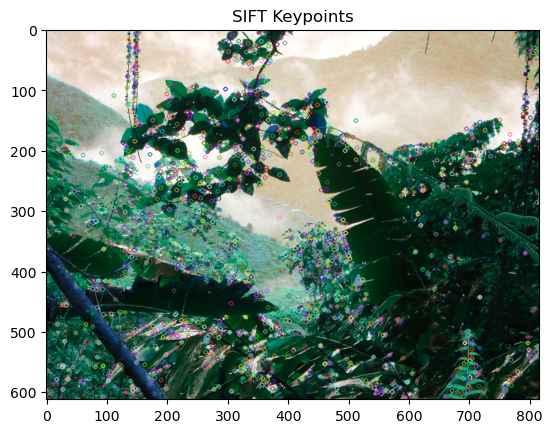

In [32]:
kps, des = extract_interest_points(query_imgs[1], 'SIFT', nfeats=2000, thresh=75)
sift_image = cv2.drawKeypoints(query_imgs[1], kps, None)

plt.imshow(sift_image)
plt.title('SIFT Keypoints')
plt.show()

### Matching images

Next, write a function called `find_matches` to match two set of descriptors. For simplicity, use a brute-force approach for binary descriptors and a FLANN-based approach for floating point descriptors:
> **Useful links**: [cv2.BFMatcher_create](https://docs.opencv.org/4.5.4/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020), [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.4/dc/de2/classcv_1_1FlannBasedMatcher.html#a7b17083dda906384465a32952c1bbe3b), [Feature Matching](https://docs.opencv.org/4.5.4/dc/dc3/tutorial_py_matcher.html)

In [33]:
def find_matches(query_desc, train_desc, k = 2):
    """
    Match two sets of descriptors. For each query descriptor, this method searches
    the k closest descriptors in the train set.
  
    - query_desc: A numpy array of shape (number_of_kps_query, descriptor_size)
    - train_desc: A numpy array of shape (number_of_kps_train, descriptor_size)
    - k: Number of nearest neighbors descriptors to retrieve
  
    RETURN:
    - A tuple where each element is an item of matches, a tuple as well, containing:
        - As first item the best match (cv2.DMatch)
        - As second item, the second best match (cv2.DMatch)
        - And so on, until k
    """

    # Case binary
    if query_desc.dtype == np.uint8:
        bf = cv2.BFMatcher_create(cv2.NORM_HAMMING, False)
        matches = bf.knnMatch(query_desc, train_desc, k=k)
    else:
        # FLANN
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=50) 
    
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(query_desc,train_desc,k=k)
    return matches

### Filtering matches

Write a function called `filter_matches` to filter the resulting matches according to the Nearest Neighbor Distance Ratio (NNDR) criterion:

In [34]:
def filter_matches(matches, ratio = 0.75):
    """
    Given a tuple of matches, apply the NNDR test to filter them.
  
    - matches: A tuple of matches. See 'find_matches' for further info
    - ratio: Ratio to be applied between the best and the second best matches
        for each query
  
    RETURN:
    - A list of filtered matches, where each item is a cv2.DMatch object
      that fullfiled the ratio test condition.
    """
    good = []
    # Store all the good matches as per Lowe's ratio test.
    for match in matches:
        if len(match) == 2:  # Ensure match is a tuple of size 2
            m, n = match
            if m.distance < ratio * n.distance:
                good.append(m)
    return good


You can check your implementation of these functions using `cv2.drawMatches`:

In [35]:
# Extract keypoints from the query image
kps_q, des_q = extract_interest_points(query_imgs[1], 'SIFT', nfeats=3000, thresh=25)

# Extract keypoints from the train image
kps_t, des_t = extract_interest_points(train_imgs[2], 'SIFT', nfeats=3000, thresh=25)

raw_matches = find_matches(des_q, des_t)
print(len(raw_matches))

3000


532


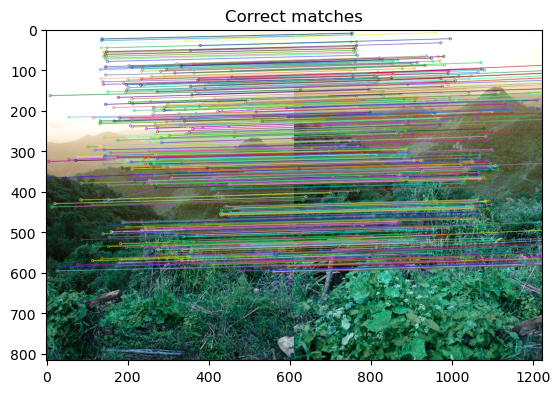

In [36]:
matches = filter_matches(raw_matches, ratio = 0.6)
print(len(matches))
img_matches = cv2.drawMatches(query_imgs[0], kps_q, train_imgs[0], kps_t, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img_matches)
plt.title('Correct matches')
plt.show()

### Performance
We can now compare images using local feature descriptors. Given a query image, its closest one in the database will be the image with the **highest number matches after filtering**. Let's reimplement our function `compute_mAP` but using local feature descriptors:

In [ ]:
def compute_mAP(query_names, query_imgs, train_names, train_imgs, feat_type='SIFT', nfeats=500, thresh=50, ratio=0.75):
    """
    Compute the Mean Average Precision (mAP) for a set of query images against a set of training images.

    - query_names: An ordered list with the names of the query images.
    - query_imgs: An ordered list of query images (Numpy arrays).
    - train_names: An ordered list with the names of the train images.
    - train_imgs: An ordered list of train images (Numpy arrays).
    - feat_type: Type of feature descriptor (e.g., 'SIFT', 'ORB').
    - nfeats: Number of features to detect (used by SIFT and ORB).
    - thresh: Detection threshold (used by FAST and ORB).
    - ratio: Ratio for filtering matches with Lowe's ratio test.

    RETURN: 
    - total_results: A dictionary with each query image name as keys and a list of sorted train image names by descending number of matches as values.
    - m_ap: Mean Average Precision averaged over all queries.
    """
    
    # Build the ground truth relevance dictionary
    gt_relevance = {}
    for query_name in query_names:
        group_id = query_name.split('.')[0][:-2]  # Assuming group_id is part of the filename before the last two digits (ex: 100900 --> 1009001,100902)
        relevant_images = [name for name in train_names if name.startswith(group_id) and name != query_name]
        gt_relevance[query_name] = set(relevant_images)
    
    total_results = {}
    ap_scores = []

    for query_name, query_img in zip(query_names, query_imgs):
        query_kp, query_des = extract_interest_points(query_img, feat_type, nfeats, thresh)

        query_results = []

        for train_name, train_img in zip(train_names, train_imgs):
            train_kp, train_des = extract_interest_points(train_img, feat_type, nfeats, thresh)
            matches = find_matches(query_des, train_des)
            filtered_matches = filter_matches(matches, ratio)
            query_results.append((train_name, len(filtered_matches)))

        query_results.sort(key=lambda x: x[1], reverse=True)
        sorted_train_names = [train_name for train_name, _ in query_results]

        # Use the actual ground truth for this query to calculate AP
        relevant_train_names = gt_relevance.get(query_name, set())
        ap = ev.compute_AP(sorted_train_names, relevant_train_names)
        ap_scores.append(ap)

        total_results[query_name] = sorted_train_names

    m_ap = sum(ap_scores) / len(ap_scores) if ap_scores else 0.0

    return total_results, m_ap

**Q8**: For each method (SIFT, FAST/BRIEF and ORB), play with its corresponding parameters in order to achieve the best possible performance in terms of mAP.


In [38]:
from itertools import product # Library for iterate

# Fill these variables with the best resulting mAPs
best_mAP_SIFT = 0.0
best_mAP_FASTBRIEF = 0.0
best_mAP_ORB = 0.0
methods = ["SIFT", "ORB", "FAST_BRIEF"]
parameters = {
    "SIFT": {
        "nfeats": [200,500,800],
        "ratio": [0.6,0.75,0.8]
    },
    "ORB": {
        "nfeats": [200,500,800],
        "thresh": [30, 50, 60],
        "ratio": [0.6,0.75,0.8]
    },
    "FAST_BRIEF": {
        "thresh": [30, 50, 60],
        "ratio": [0.6,0.75,0.8]
    }
}


results = []
for method, params in parameters.items():
    keys = params.keys()
    values = params.values()
    #print(f"Calculating {method}")
    for comb in product(*values):
        param_dict = dict(zip(keys, comb))

        # Getting parameters data
        nfeats = param_dict.get("nfeats", 500)
        thresh = param_dict.get("thresh", 50)
        ratio = param_dict.get("ratio",0.75)
        #print(f"With parameters nfeats:{nfeats}, thresh:{thresh} ratio:{ratio}")
        _, m_ap = compute_mAP(query_names, query_imgs, train_names, train_imgs, method, nfeats, thresh, ratio)
        
        # Saving results and information for each combination
        results.append({"method": method, "parameters":param_dict, "m_ap": m_ap})

In [39]:
best_result_by_method = {}

for result in results:
    method = result['method']
    m_ap = result['m_ap']

    # If the method is not in the dictionary or the current m_ap is greater than the max, update the dictionary
    if method not in best_result_by_method or m_ap > best_result_by_method[method]:
        best_result_by_method[method] = m_ap
print('Best mAP (SIFT): %.5f' % best_result_by_method['SIFT'])
print('Best mAP (FAST/BRIEF): %.5f' % best_result_by_method['FAST_BRIEF'])
print('Best mAP (ORB): %.5f' % best_result_by_method['ORB'])


Best mAP (SIFT): 0.85153
Best mAP (FAST/BRIEF): 0.72726
Best mAP (ORB): 0.73173


**Q9**: Compare the three different methods in terms of accuracy. Which one is the most accurate method? Which one is the least?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

#### Q9 response
The Mean Average Precision (mAP) is a metric commonly used to measure the accuracy of object detectors. A higher mAP indicates greater accuracy.  
  
To compare the mAP of different methods, ensure that the input parameters, number of features, threshold, and ratio are consistent across all methods, while considering which parameters each method uses.  
- SIFT has the highest mAP of 0.85153, making it the most accurate method of the three.  
- FAST/BRIEF has the lowest mAP of 0.72726, making it the least accurate method.  
- ORB has a mAP of 0.73173, which is slightly better than FAST/BRIEF but still less accurate than SIFT.  

Due to the potential variation in scale, illumination, and affine distortion of the images in the dataset, it is reasonable to expect that SIFT would achieve greater accuracy.

**Q10**: Compare the three different methods in terms of detection/description speed. Which one is the fastest method? Which one is the slowest?

> **Hints**:
> - [Here](https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html) you can find a useful link about timing in Jupyter Notebooks
> - You can also consider using the `time` module
> - To provide a measure independent of the number of features found in the image, you can compute, for instance, features / ms

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

## Submitting your work

**Important**: Please make sure that the submitted notebooks have been run and the cell outputs are visible.

**Important**: Please make also sure that you have filled the **NAME** and **DNI** variables at the beginning of the notebook, **using the indicated format**.

Once you have filled out the necessary code and you are happy with your solution, **save your notebook** and execute the following cell:

In [ ]:
zip_filename = DNI + '_A1.zip'
zf = zipfile.ZipFile(zip_filename, mode = 'w')

aname = 'submitted/' + DNI + '/A1/Image_Descriptors.ipynb'
zf.write('Image_Descriptors.ipynb', arcname = aname);

zf.close()

This will generate a zip file of your code called `DNI_A1.zip` in the same directory of the assignment. This is the file that you must upload to [Aula Digital](https://ad.uib.es/) to submit your work!

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands